In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from time import time
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit

In [109]:
pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [110]:
df = pd.read_csv('bank.csv')

In [111]:
tmp = pd.read_csv('bank.csv')

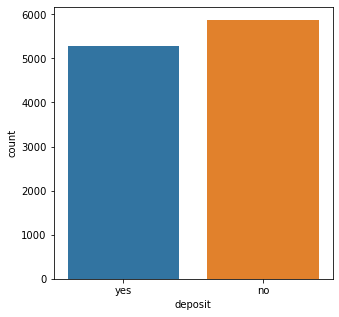

In [112]:
plt.figure(figsize = (5,5))
sns.countplot(x="deposit", data=tmp)
plt.show()

In [113]:
df.shape

(11162, 17)

In [114]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [115]:
df['deposit'].unique()

array(['yes', 'no'], dtype=object)

## Continuous Feature

In [116]:
cont_feat = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [117]:
def describe_cont_feature(feature):
    print('\n*** Results for {} ***'.format(feature))
    print(df.groupby('deposit')[feature].describe())

In [118]:
for feat in cont_feat:
    describe_cont_feature(feat)


*** Results for age ***
          count       mean        std   min   25%   50%   75%   max
deposit                                                            
no       5873.0  40.837391  10.264815  18.0  33.0  39.0  48.0  89.0
yes      5289.0  41.670070  13.497781  18.0  31.0  38.0  50.0  95.0

*** Results for balance ***
          count         mean          std     min    25%    50%     75%  \
deposit                                                                   
no       5873.0  1280.227141  2933.411934 -6847.0   64.0  414.0  1324.0   
yes      5289.0  1804.267915  3501.104777 -3058.0  210.0  733.0  2159.0   

             max  
deposit           
no       66653.0  
yes      81204.0  

*** Results for day ***
          count       mean       std  min  25%   50%   75%   max
deposit                                                         
no       5873.0  16.108122  8.322071  1.0  9.0  16.0  22.0  31.0
yes      5289.0  15.158253  8.501875  1.0  8.0  15.0  22.0  31.0

*** Results

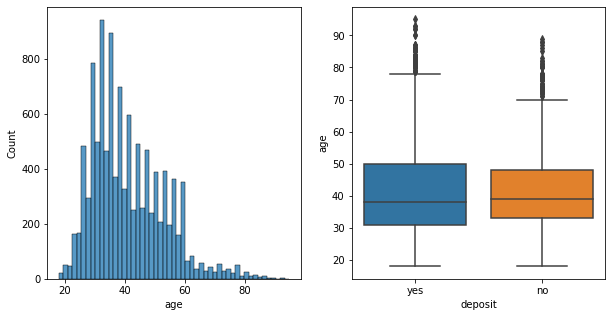

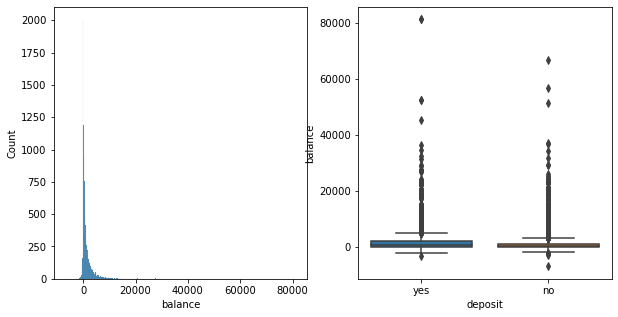

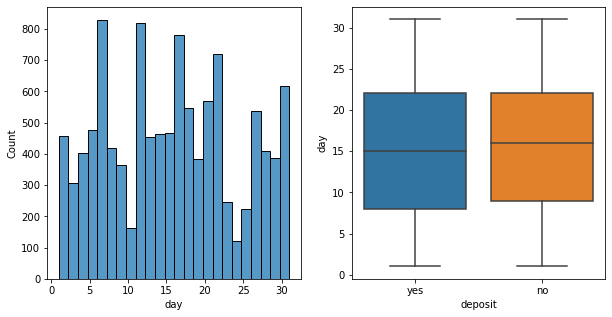

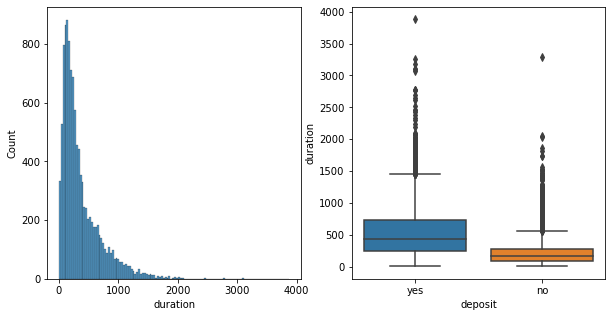

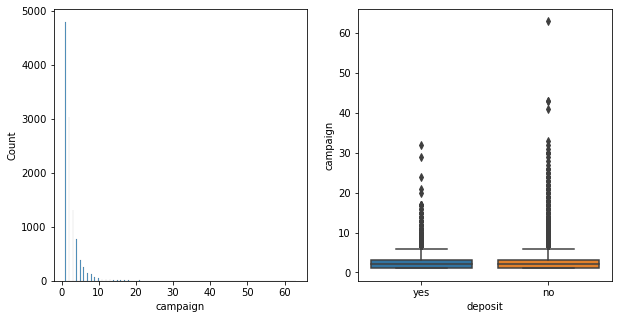

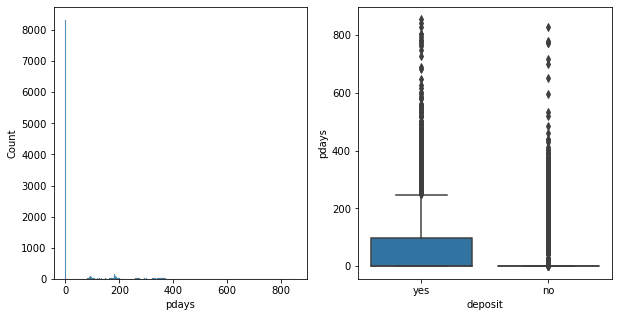

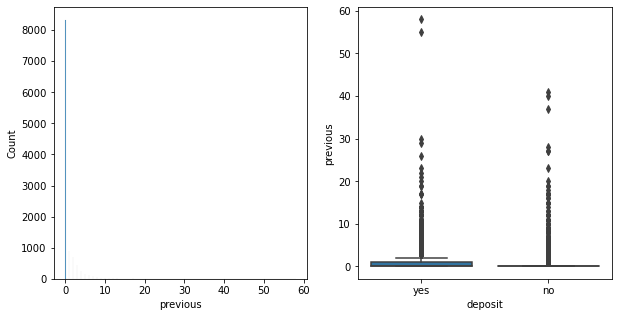

In [119]:
for col in cont_feat:
    f, ax = plt.subplots(1, 2, figsize = (10, 5))
    sns.histplot(data = df, x = col, ax=ax[0])
    sns.boxplot(x='deposit',y=col, data=df, ax=ax[1])
    plt.show()

In [120]:
df['deposit'].value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

In [121]:
def detect_outliers(feature):
    outliers = []
    data = df[feature]
    mean = np.mean(data)
    std = np.std(data)
    
    for y in data:
        z_score = (y - mean) / std
        if np.abs(z_score) > 3:
            outliers.append(y)
    print('\n Outliers caps for {}: '.format(feature))
    print('  --95p: {:.1f} / {} values exceed that'.format(data.quantile(.95),
                                                          len([i for i in data if i > data.quantile(.95)])))
    print('  --3sd: {:.1f} / {} values exceed that'.format(mean + 3 * std, len(outliers)))
    print('  --99p: {:.1f} / {} values exceed that'.format(data.quantile(.99), 
                                                          len([i for i in data if i > data.quantile(.99)])))

In [122]:
# for feat in cont_feat:
#     detect_outliers(feat)

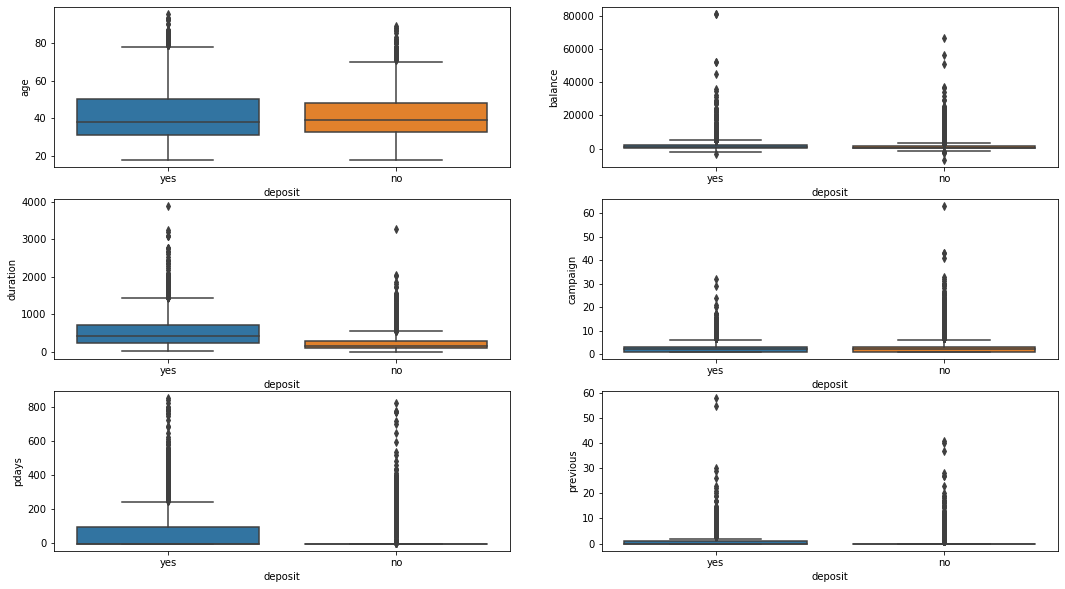

In [124]:
# age, balance, duration, campaign, pdays and previous
f, ax = plt.subplots(3, 2, figsize = (18, 10))
sns.boxplot(x='deposit',y='age', data=df, ax=ax[0, 0])
sns.boxplot(x='deposit',y='balance', data=df, ax=ax[0, 1])
sns.boxplot(x='deposit',y='duration', data=df, ax=ax[1, 0])
sns.boxplot(x='deposit',y='campaign', data=df, ax=ax[1, 1])
sns.boxplot(x='deposit',y='pdays', data=df, ax=ax[2, 0])
sns.boxplot(x='deposit',y='previous', data=df, ax=ax[2, 1])
plt.show()

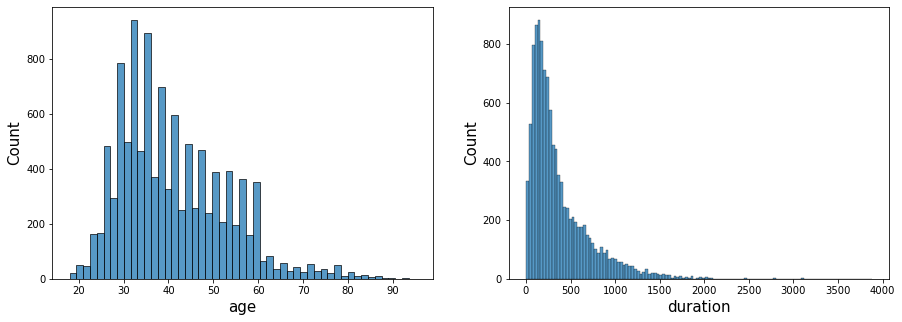

In [105]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
i = 0
for col in ['age', 'duration']:
    fig = sns.histplot((df[col]), ax = ax[i])
    fig.set_xlabel(f'{col}', fontsize=15)
    fig.set_ylabel('Count',fontsize=15)
    i+=1

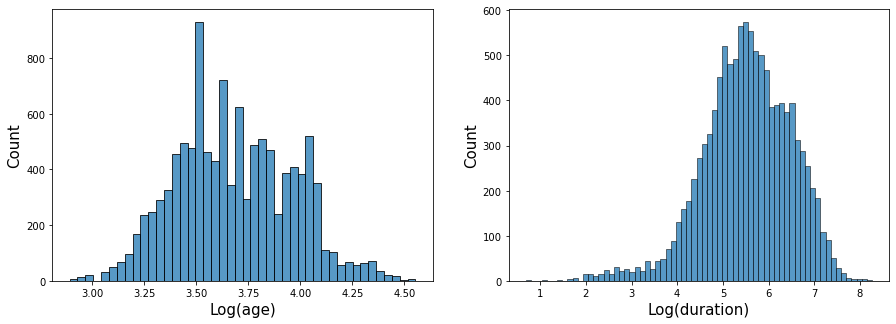

In [103]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
i = 0
for col in ['age', 'duration']:
    fig = sns.histplot(np.log(df[col]), ax = ax[i])
    fig.set_xlabel(f'Log({col})', fontsize=15)
    fig.set_ylabel('Count',fontsize=15)
    i+=1

### Remove Outiers

In [14]:
for feat in cont_feat:
    df[feat].clip(upper = df[feat].quantile(.99), inplace = True)

## Categorical Variables

In [15]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042.0,1,-1.0,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467.0,1,-1.0,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389.0,1,-1.0,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579.0,1,-1.0,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673.0,2,-1.0,0,unknown,yes


In [16]:
df['deposit'] = df['deposit'].replace({'yes':1,'no':0})

In [17]:
cat_feat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

<Figure size 720x360 with 0 Axes>

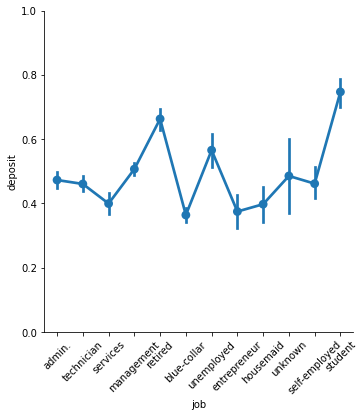

<Figure size 720x360 with 0 Axes>

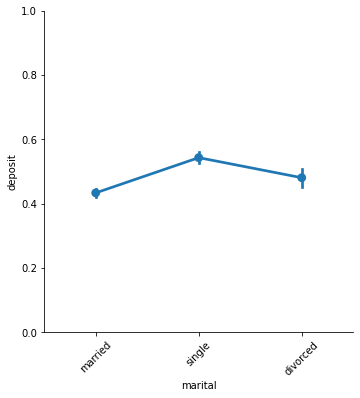

<Figure size 720x360 with 0 Axes>

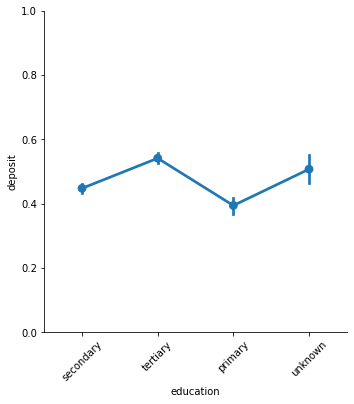

<Figure size 720x360 with 0 Axes>

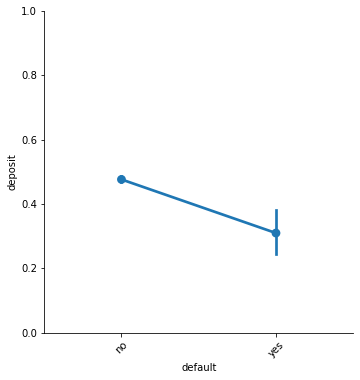

<Figure size 720x360 with 0 Axes>

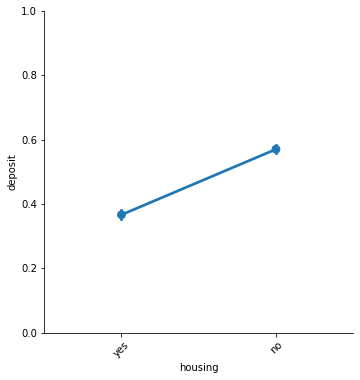

<Figure size 720x360 with 0 Axes>

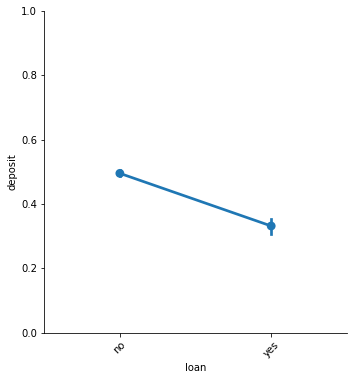

<Figure size 720x360 with 0 Axes>

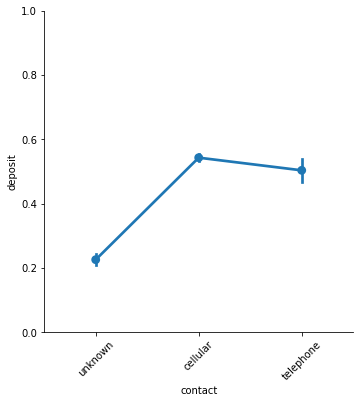

<Figure size 720x360 with 0 Axes>

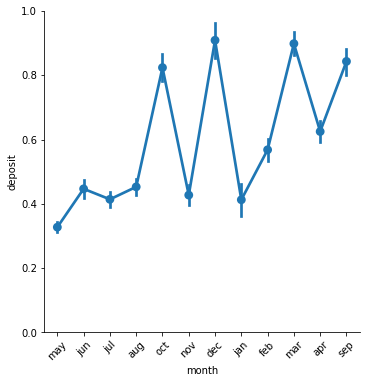

<Figure size 720x360 with 0 Axes>

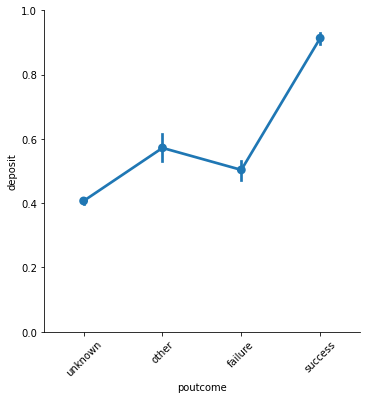

In [18]:
for col in cat_feat:
    plt.figure(figsize = (10,5))
    sns.catplot(x = col, y = 'deposit', data = df, kind = 'point', ascept = 2)
    plt.ylim(0, 1)
    plt.xticks(rotation = 45)
    plt.show()

C:\Users\mayursaid\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


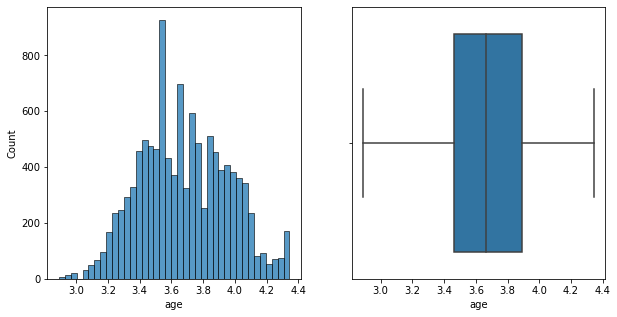

C:\Users\mayursaid\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


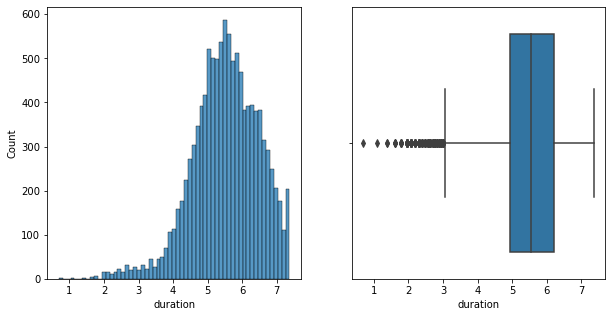

In [19]:
for col in ['age', 'duration']:
    f, ax = plt.subplots(1, 2, figsize = (10, 5))
    sns.histplot(np.log(df[col]), ax=ax[0])
    sns.boxplot(np.log(df[col]), ax=ax[1])
    plt.show()

## Transformation

In [20]:
df['log_age'] = np.log(df['age'])
df['log_duration'] = np.log(df['duration'])

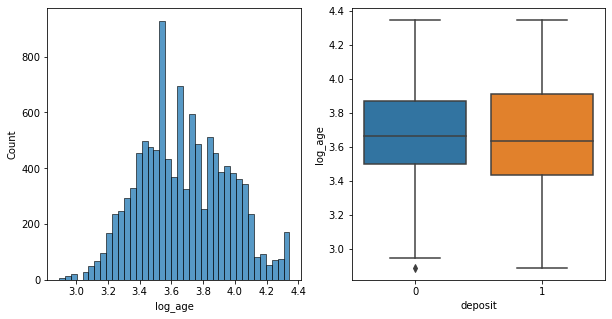

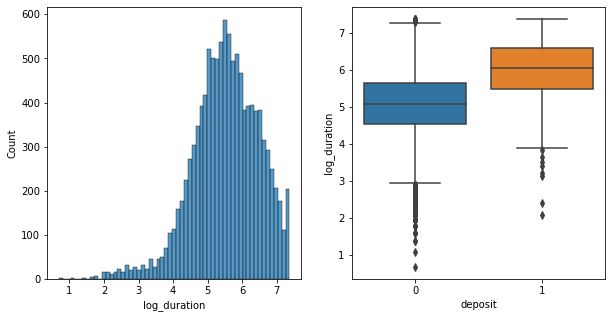

In [21]:
for col in ['log_age', 'log_duration']:
    f, ax = plt.subplots(1, 2, figsize = (10, 5))
    sns.histplot(data = df, x = col, ax=ax[0])
    sns.boxplot(x='deposit',y=col, data=df, ax=ax[1])
    plt.show()

In [22]:
df_final = df.drop(['age', 'duration'], axis=1)

In [23]:
cat_feat

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [24]:
for col in cat_feat:
    dummy_cols = pd.get_dummies(df_final[col], drop_first=True, prefix=col)
    df_final = pd.concat([df_final,dummy_cols],axis=1)
    df_final.drop(columns=col, inplace=True)

In [25]:
df_final.head()

,balance,day,campaign,pdays,previous,deposit,log_age,log_duration,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,2343.0,5,1,-1.0,0,1,4.077537,6.948897,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,45.0,5,1,-1.0,0,1,4.025352,7.290975,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,1270.0,5,1,-1.0,0,1,3.713572,7.236339,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,2476.0,5,1,-1.0,0,1,4.007333,6.361302,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,184.0,5,2,-1.0,0,1,3.988984,6.511745,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1


## Train Val Test Split

In [26]:
y = df_final['deposit'].copy()
X = df_final.drop(['deposit'], axis=1)

In [27]:
#split dataset in training, validation and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state =42)

In [28]:
X_train.head()

,balance,day,campaign,pdays,previous,log_age,log_duration,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
10327,5381.0,17,1,-1.0,0,3.401197,5.926926,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
6902,131.0,8,1,-1.0,0,3.401197,5.723585,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
5648,-207.0,2,1,-1.0,0,4.007333,5.351858,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
9462,12.0,17,1,-1.0,0,3.465736,5.771441,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
6232,-199.0,29,1,-1.0,0,3.891820,5.953243,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [29]:
X_train.shape, y_train.shape

((6697, 42), (6697,))

In [30]:
y_train.value_counts()

0    3571
1    3126
Name: deposit, dtype: int64

In [31]:
for dataset in [y_train, y_val, y_test]:
    print(round(len(dataset) / len(y), 2))

0.6
0.2
0.2


### Scaling

In [32]:
scaler = MinMaxScaler()

In [33]:
X_train = scaler.fit_transform(X_train)

In [34]:
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [35]:
X_train[:2]

array([[0.51820758, 0.53333333, 0.        , 0.        , 0.        ,
        0.35146126, 0.78464623, 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 1.        ],
       [0.19582462, 0.23333333, 0.        , 0.        , 0.        ,
        0.35146126, 0.75416144, 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.     

## Smote

In [36]:
sm = SMOTE(random_state = 100)

In [37]:
X_train, y_train = sm.fit_resample(X_train, y_train)

In [38]:
df.shape

(11162, 19)

In [39]:
pd.DataFrame(X_train).shape

(7142, 42)

## Training

In [40]:
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    auc_roc = round(roc_auc_score(labels, pred), 3)
    precision = round(precision_score(labels, pred), 3)
    recall = round(recall_score(labels, pred), 3)
    print('{} -- \tAUC_ROC: {} / Precision: {} / Recall: {} / Latency: {}ms'.format(name,
                                                                                     auc_roc,
                                                                                     precision,
                                                                                     recall,
                                                                                     round((end - start)*1000, 1)))
    return auc_roc, precision, recall
    

### Logistic Regression

In [41]:
scores = []

In [42]:
params = {
    'C': [100, 10, 1.0, 0.1, 0.01]
}

In [43]:
LR = LogisticRegression(max_iter=10000)
grid_LR = GridSearchCV(estimator=LR, param_grid=params, n_jobs=-1, cv=10, scoring='f1')
grid_LR.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01]}, scoring='f1')

In [44]:
train_auc_roc, train_precision, train_recall = evaluate_model('LR', grid_LR, X_train, y_train)

LR -- 	AUC_ROC: 0.832 / Precision: 0.822 / Recall: 0.848 / Latency: 1.0ms


In [45]:
val_auc_roc, val_precision, val_recall = evaluate_model('LR', grid_LR, X_val, y_val)

LR -- 	AUC_ROC: 0.825 / Precision: 0.799 / Recall: 0.848 / Latency: 1.0ms


In [46]:
test_auc_roc, test_precision, test_recall = evaluate_model('LR', grid_LR, X_test, y_test)

LR -- 	AUC_ROC: 0.82 / Precision: 0.811 / Recall: 0.824 / Latency: 0.0ms


In [47]:
model_name = 'Logistic Regression'

scores.append({
    'Model': model_name,
    'Train AUC ROC': train_auc_roc,
    'Val AUC ROC': val_auc_roc,
    'Test AUC ROC Score': test_auc_roc,
    'Test Precision': test_precision,
    'Test Recall': test_recall
})

### SVM

In [48]:
from sklearn import svm

In [49]:
#Create a svm Classifier
svm = svm.SVC(gamma = 'auto', probability=True)

#Train the model using the training sets
svm.fit(X_train, y_train)

SVC(gamma='auto', probability=True)

In [50]:
evaluate_model('SVM', svm, X_test, y_test)

SVM -- 	AUC_ROC: 0.827 / Precision: 0.8 / Recall: 0.859 / Latency: 1117.0ms


(0.827, 0.8, 0.859)

In [51]:
train_auc_roc, train_precision, train_recall = evaluate_model('svm', svm, X_train, y_train)

svm -- 	AUC_ROC: 0.838 / Precision: 0.809 / Recall: 0.886 / Latency: 3567.6ms


In [52]:
val_auc_roc, val_precision, val_recall = evaluate_model('svm', svm, X_val, y_val)

svm -- 	AUC_ROC: 0.822 / Precision: 0.781 / Recall: 0.869 / Latency: 1117.5ms


In [53]:
test_auc_roc, test_precision, test_recall = evaluate_model('svm', svm, X_test, y_test)

svm -- 	AUC_ROC: 0.827 / Precision: 0.8 / Recall: 0.859 / Latency: 1116.1ms


In [54]:
model_name = 'SVM'

scores.append({
    'Model': model_name,
    'Train AUC ROC': train_auc_roc,
    'Val AUC ROC': val_auc_roc,
    'Test AUC ROC Score': test_auc_roc,
    'Test Precision': test_precision,
    'Test Recall': test_recall
})

### Decision Tree

In [55]:
from sklearn.tree import DecisionTreeClassifier

In [56]:
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [57]:
# DT = DecisionTreeClassifier()

# # Train Decision Tree Classifer
# DT = clf.fit(X_train,y_train)

In [58]:
DT = DecisionTreeClassifier()
grid_DT = GridSearchCV(estimator=DT, param_grid=params, n_jobs=-1, cv=10, scoring='roc_auc')
grid_DT.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='roc_auc')

In [59]:
train_auc_roc, train_precision, train_recall = evaluate_model('DT', grid_DT, X_train, y_train)

DT -- 	AUC_ROC: 0.841 / Precision: 0.827 / Recall: 0.862 / Latency: 2.0ms


In [60]:
val_auc_roc, val_precision, val_recall = evaluate_model('DT', grid_DT, X_val, y_val)

DT -- 	AUC_ROC: 0.818 / Precision: 0.794 / Recall: 0.836 / Latency: 2.0ms


In [61]:
test_auc_roc, test_precision, test_recall = evaluate_model('DT', grid_DT, X_test, y_test)

DT -- 	AUC_ROC: 0.817 / Precision: 0.809 / Recall: 0.818 / Latency: 1.0ms


In [62]:
model_name = 'DT'

scores.append({
    'Model': model_name,
    'Train AUC ROC': train_auc_roc,
    'Val AUC ROC': val_auc_roc,
    'Test AUC ROC Score': test_auc_roc,
    'Test Precision': test_precision,
    'Test Recall': test_recall
})

### Random Forest

In [63]:
# xgb_model = XGBClassifier(random_state=100, use_label_encoder=False, n_jobs=-1)

# xgb_model.fit(X_train, y_train)

In [64]:
params = {
    'n_estimators': [2**i for i in range(3, 10)],
    'max_depth': [2, 4, 8, 16, 32, 64, None],
}

In [65]:
RF = RandomForestClassifier()
grid_RF = GridSearchCV(RF, params, cv = 10, scoring = 'roc_auc', n_jobs = -1)
grid_RF.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 8, 16, 32, 64, None],
                         'n_estimators': [8, 16, 32, 64, 128, 256, 512]},
             scoring='roc_auc')

In [66]:
train_auc_roc, train_precision, train_recall = evaluate_model('RF', grid_RF, X_train, y_train)

RF -- 	AUC_ROC: 1.0 / Precision: 1.0 / Recall: 1.0 / Latency: 516.0ms


In [67]:
val_auc_roc, val_precision, val_recall = evaluate_model('RF', grid_RF, X_val, y_val)

RF -- 	AUC_ROC: 0.846 / Precision: 0.807 / Recall: 0.887 / Latency: 207.0ms


In [68]:
test_auc_roc, test_precision, test_recall = evaluate_model('RF', grid_RF, X_test, y_test)

RF -- 	AUC_ROC: 0.849 / Precision: 0.825 / Recall: 0.876 / Latency: 201.0ms


In [69]:
model_name = 'RF'

scores.append({
    'Model': model_name,
    'Train AUC ROC': train_auc_roc,
    'Val AUC ROC': val_auc_roc,
    'Test AUC ROC Score': test_auc_roc,
    'Test Precision': test_precision,
    'Test Recall': test_recall
})

## XgBoost

In [70]:
params = {
    'n_estimators': [2**i for i in range(3, 10)],
    'learning_rate': np.arange(0.01, 0.1, 0.01),
    'max_depth': np.arange(1, 10, 1),
    'subsample': np.arange(0, 1.1, 0.1),
    'min_child_weight': [1, 2, 3, 4, 5, 10, 50, 100],
    'reg_alpha': [1, 2, 3, 4, 5, 10, 50, 100],
    'reg_lambda':  [1, 2, 3, 4, 5, 10, 50, 100],
    'colsample_bytree':  np.arange(0, 1.1, 0.1),
    'colsample_bylevel':  np.arange(0, 1.1, 0.1),
}

In [71]:
xgb = XGBClassifier(objective = 'binary:logistic')

In [72]:
random_xgb = RandomizedSearchCV(xgb, params, cv = 5, scoring = 'roc_auc',
                                 n_iter = 500, random_state = 10, return_train_score = False, n_jobs = -1)
random_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                        'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                  

In [73]:
train_auc_roc, train_precision, train_recall = evaluate_model('XGB', random_xgb, X_train, y_train)

XGB -- 	AUC_ROC: 0.903 / Precision: 0.88 / Recall: 0.934 / Latency: 12.0ms


In [74]:
val_auc_roc, val_precision, val_recall = evaluate_model('XGB', random_xgb, X_val, y_val)

XGB -- 	AUC_ROC: 0.86 / Precision: 0.825 / Recall: 0.895 / Latency: 6.0ms


In [75]:
test_auc_roc, test_precision, test_recall = evaluate_model('XGB', random_xgb, X_test, y_test)

XGB -- 	AUC_ROC: 0.854 / Precision: 0.835 / Recall: 0.872 / Latency: 6.0ms


In [76]:
pd.DataFrame(scores)

model_name = 'XGB'

scores.append({
    'Model': model_name,
    'Train AUC ROC': train_auc_roc,
    'Val AUC ROC': val_auc_roc,
    'Test AUC ROC Score': test_auc_roc,
    'Test Precision': test_precision,
    'Test Recall': test_recall
})

In [77]:
pd.DataFrame(scores)

,Model,Train AUC ROC,Val AUC ROC,Test AUC ROC Score,Test Precision,Test Recall
0,Logistic Regression,0.832,0.825,0.820,0.811,0.824
1,SVM,0.838,0.822,0.827,0.800,0.859
2,DT,0.841,0.818,0.817,0.809,0.818
3,RF,1.000,0.846,0.849,0.825,0.876
4,XGB,0.903,0.860,0.854,0.835,0.872


In [78]:
pd.DataFrame(scores)

,Model,Train AUC ROC,Val AUC ROC,Test AUC ROC Score,Test Precision,Test Recall
0,Logistic Regression,0.832,0.825,0.820,0.811,0.824
1,SVM,0.838,0.822,0.827,0.800,0.859
2,DT,0.841,0.818,0.817,0.809,0.818
3,RF,1.000,0.846,0.849,0.825,0.876
4,XGB,0.903,0.860,0.854,0.835,0.872


In [79]:
def cal_f1_score(precision, recall):
    return round(2 * (precision * recall)/(precision + recall), 3)

results = pd.DataFrame(scores)
results['Test F1 Score'] = cal_f1_score(results['Test Precision'], results['Test Recall'])

In [80]:
#One-hot-Encoding

In [81]:
results

,Model,Train AUC ROC,Val AUC ROC,Test AUC ROC Score,Test Precision,Test Recall,Test F1 Score
0,Logistic Regression,0.832,0.825,0.820,0.811,0.824,0.817
1,SVM,0.838,0.822,0.827,0.800,0.859,0.828
2,DT,0.841,0.818,0.817,0.809,0.818,0.813
3,RF,1.000,0.846,0.849,0.825,0.876,0.850
4,XGB,0.903,0.860,0.854,0.835,0.872,0.853
